In [1]:
import ROOT

from ROOT import TCanvas, TFile
import numpy as np

import time

/opt/local/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cppyy/__init__.py:72: SyntaxWarning: invalid escape sequence '\d'
  if re.match('^libcppyy_backend\d+_\d+$', lib_name):


Welcome to JupyROOT 6.30/04


In [2]:
contours = np.array([0.5, 0.8, 0.9, 0.99, 1])

In [3]:
files = {}
files["pienu"] = TFile("pienu_job_output.root")
files["pimue"] = TFile("pimue_job_output.root")

In [4]:
h_pistop_rec_xy_5hits = {}
h_pistop_rec_xy = {}
h_pistop_rec_xy_5hits_eff = {}
for k, v in files.items():
    h_pistop_rec_xy_5hits[k] = v.Get("h_pistop_rec_xy_5hits")
    h_pistop_rec_xy_5hits[k].SetName("{}_{}".format(h_pistop_rec_xy_5hits[k].GetName(), k))
    h_pistop_rec_xy[k] = v.Get("h_pistop_rec_xy")
    h_pistop_rec_xy[k].SetName("{}_{}".format(h_pistop_rec_xy[k].GetName(), k))

    h_pistop_rec_xy_5hits_eff[k] = h_pistop_rec_xy_5hits[k].Clone("h_pistop_rec_xy_5hits_eff_{}".format(k))
    h_pistop_rec_xy_5hits_eff[k].Divide(h_pistop_rec_xy[k])

In [5]:
for k, v in h_pistop_rec_xy_5hits_eff.items():
    v.SetTitle("{} Eff. = 5 e+ hits / all".format(k))
    v.SetStats(0)

In [6]:
# c = TCanvas("c", "c", 800*2, 800*2)
# c.Divide(2, 2)
c = TCanvas("c", "c", 800*2, 800)
c.Divide(2, 1)
# for i in range(1, 5):
for i in range(1, 3):
    pad = c.cd(i)
    pad.SetTopMargin(0.15)
    pad.SetBottomMargin(0.15)
    pad.SetLeftMargin(0.15)
    pad.SetRightMargin(0.15)

In [7]:
for k, v in h_pistop_rec_xy_5hits_eff.items():
    v.SetContour(len(contours), contours)
    v.SetMinimum(contours[0])

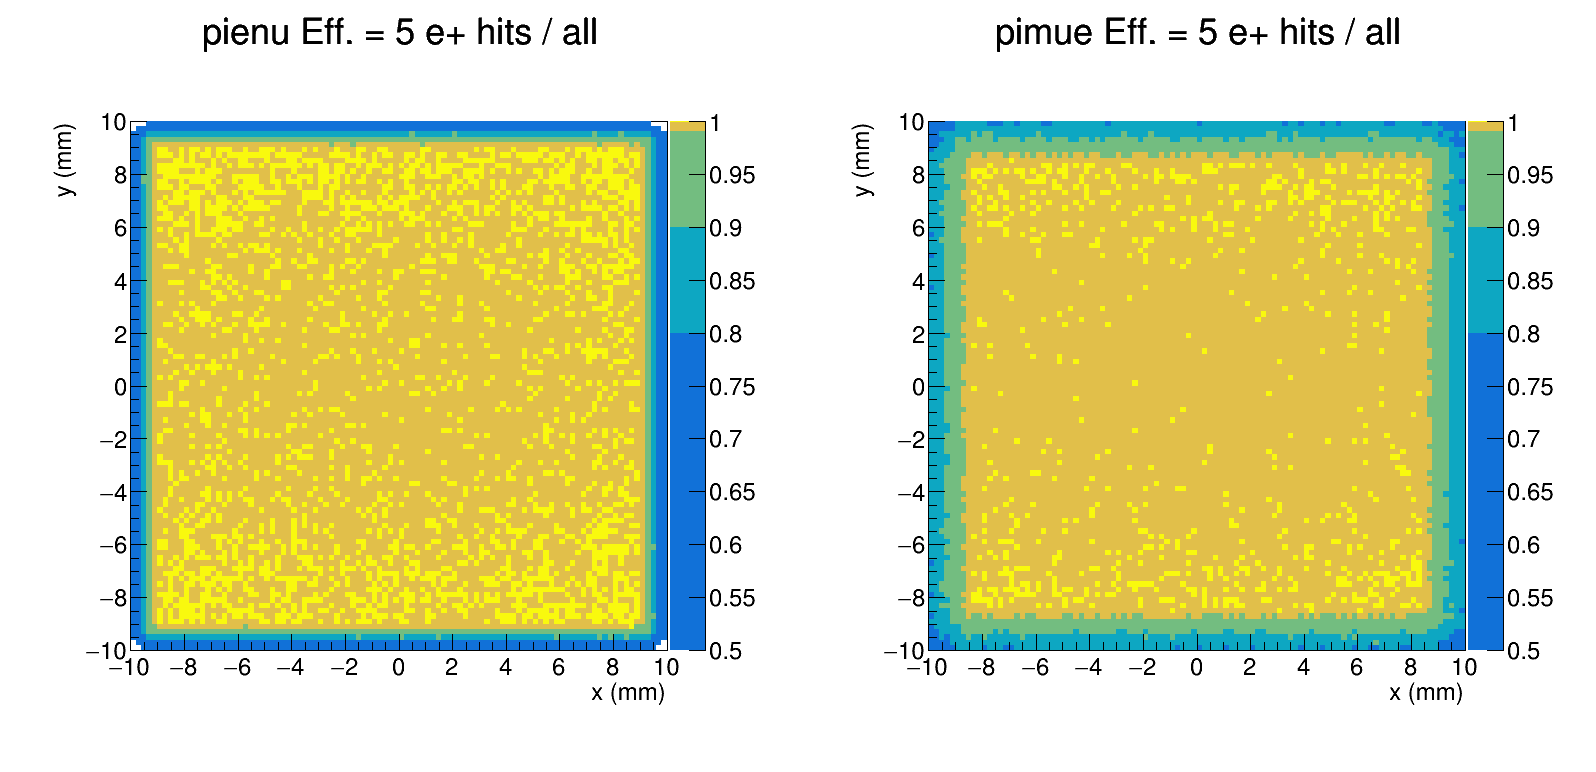

In [8]:
# palettes = []
c.Draw()
c.cd(1)
h_pistop_rec_xy_5hits_eff["pienu"].DrawClone("COLZ")
# palettes.append(h_pistop_rec_xy_5hits_eff["pienu"].GetListOfFunctions().FindObject("palette"))
# c.cd(1)
# h_pistop_rec_xy_5hits_eff["pienu"].Draw("CONT Z LIST")
# palettes.append(h_pistop_rec_xy_5hits_eff["pienu"].GetListOfFunctions().FindObject("palette"))
c.cd(2)
h_pistop_rec_xy_5hits_eff["pimue"].DrawClone("COLZ")
# palettes.append(h_pistop_rec_xy_5hits_eff["pimue"].GetListOfFunctions().FindObject("palette"))
# c.cd(2)
# h_pistop_rec_xy_5hits_eff["pimue"].Draw("CONT Z LIST")
# palettes.append(h_pistop_rec_xy_5hits_eff["pimue"].GetListOfFunctions().FindObject("palette"))

In [9]:
def getratios(h2d, bin1, bin2, xory):
    h = None
    start = None
    end = None
    if xory == 'x':
        h = h2d.ProjectionX("{}_{}axis_bin{:d}to{:d}".format(h2d.GetName(), xory, bin1, bin2), bin1, bin2)
        start = h2d.GetXaxis().GetBinLowEdge(bin1)
        end = h2d.GetXaxis().GetBinLowEdge(bin2+1)
    if xory == 'y':
        h = h2d.ProjectionY("{}_{}axis_bin{:d}to{:d}".format(h2d.GetName(), xory, bin1, bin2), bin1, bin2)
        start = h2d.GetYaxis().GetBinLowEdge(bin1)
        end = h2d.GetYaxis().GetBinLowEdge(bin2+1)
    h.SetTitle("{:.2f} mm to {:.2f} mm".format(start, end))
    return h

In [10]:
def getbins(h2d, val1, val2, xory):
    ret1 = None
    ret2 = None
    if xory == 'x':
        ret1 = h2d.GetXaxis().FindBin(val1)
        ret2 = h2d.GetXaxis().FindBin(val2) - 1
    if xory == 'y':
        ret1 = h2d.GetYaxis().FindBin(val1)
        ret2 = h2d.GetYaxis().FindBin(val2) - 1
    return ret1, ret2

In [11]:
ledge = [-8, -6, -4, -2, 0, 2, 4, 6]
redge = [ -6, -4, -2, 0, 2, 4, 6, 8]
h5hits = {"pienu" : [], "pimue" : []}
hall = {"pienu" : [], "pimue" : []}
for k in ["pienu", "pimue"]:
    for left, right in zip(ledge, redge):
        h5hits[k].append({"x": None, "y": None})
        hall[k].append({"x": None, "y": None})
        for axis in ['x', 'y']:
            bin1, bin2 = getbins(h_pistop_rec_xy_5hits[k], left, right, axis)
            h5hits[k][-1][axis] = getratios(h_pistop_rec_xy_5hits[k], bin1, bin2, axis)
            hall[k][-1][axis] = getratios(h_pistop_rec_xy[k], bin1, bin2, axis)
            h5hits[k][-1][axis].Rebin(10)
            hall[k][-1][axis].Rebin(10)

In [12]:
gs = {"pienu" : [], "pimue": []}
for k in ["pienu", "pimue"]:
    for i in range(len(ledge)):
        gs[k].append( { 'x' : None, 'y' : None } )
        for axis in ['x', 'y']:
            gs[k][i][axis] = ROOT.TGraphAsymmErrors()
            gs[k][i][axis].Divide(h5hits[k][i][axis], hall[k][i][axis])
            gs[k][i][axis].SetTitle("{}".format(h5hits[k][i][axis].GetTitle()))
            gs[k][i][axis].GetXaxis().SetTitle(h5hits[k][i][axis].GetXaxis().GetTitle())

In [13]:
ceff = TCanvas("ceff", "Efficiency", 800*4, 600*4)
ceff.Divide(4, 4)

Info in <TCanvas::Print>: png file pistop_xy_eff.png has been created


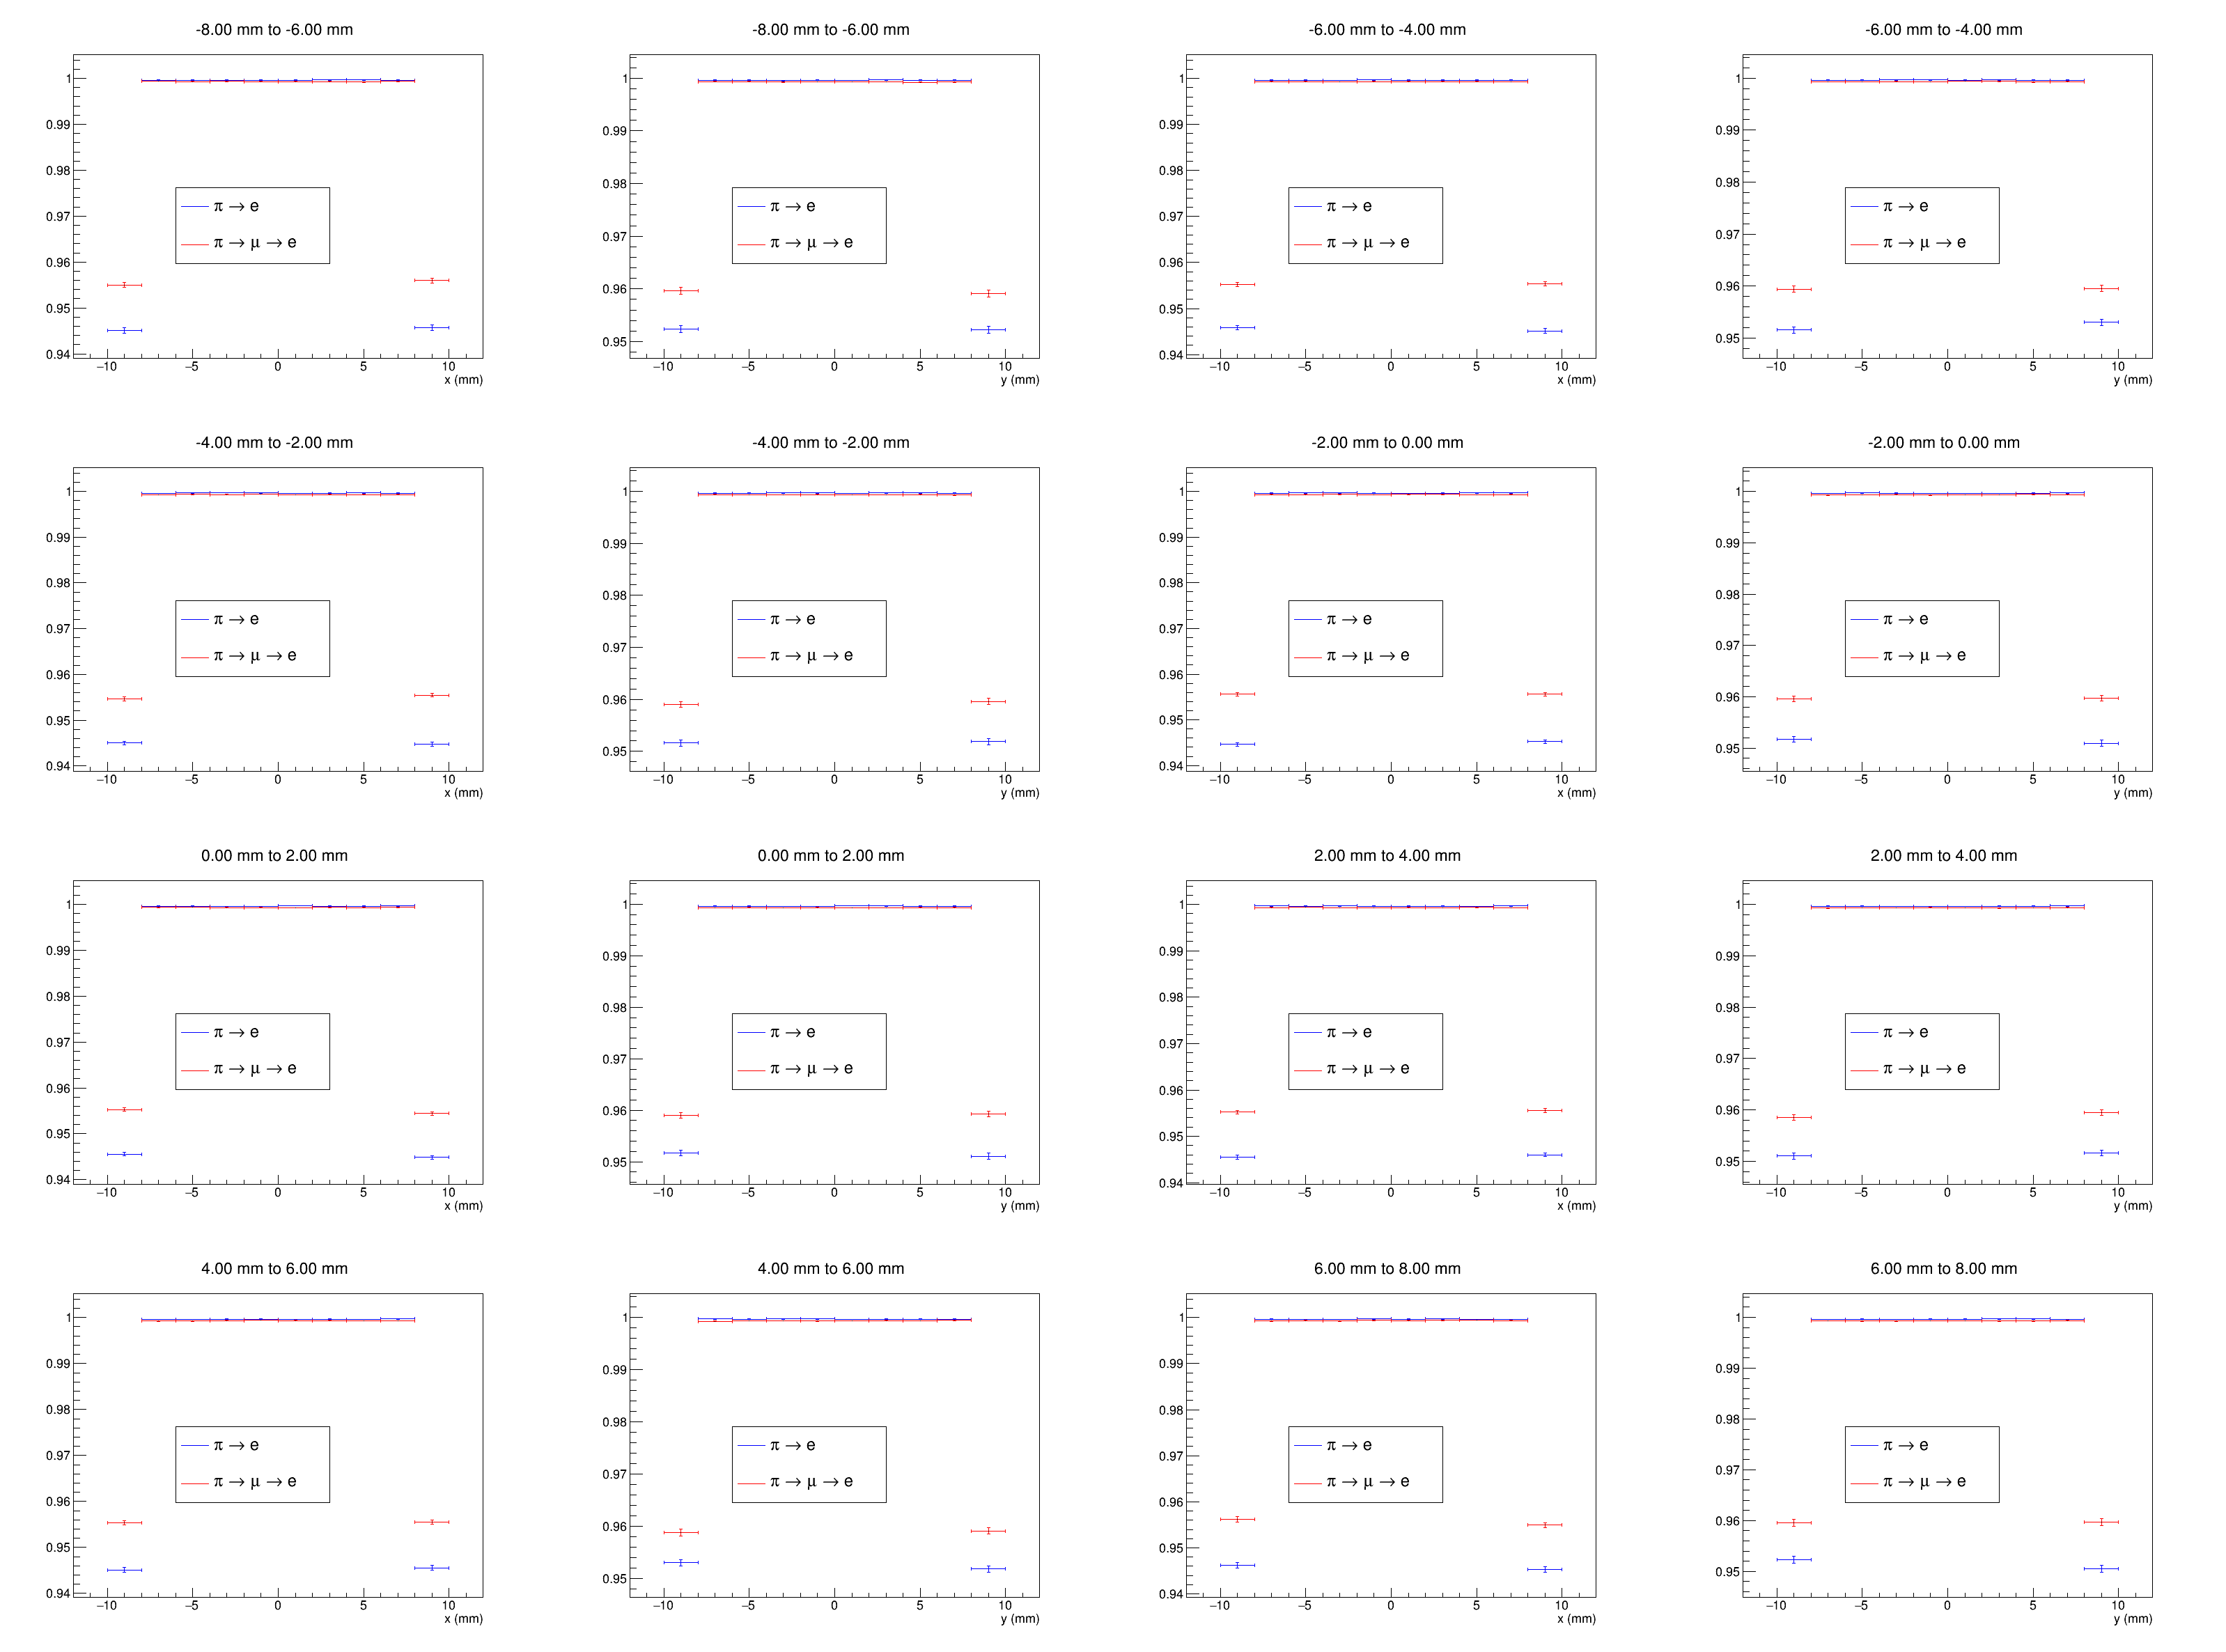

In [28]:
pads = []
for i in range(8):
    for j in range(2):
        pad = ceff.cd(2*i + j + 1)
        axis = None
        if j == 0:
            axis = 'x'
        if j == 1:
            axis = 'y'
        gs["pienu"][i][axis].SetLineColor(ROOT.kBlue)
        gs["pimue"][i][axis].SetLineColor(ROOT.kRed)
        gs["pienu"][i][axis].Draw("AP")
        gs["pimue"][i][axis].Draw("P")
        leg = ROOT.TLegend(0.3, 0.35, 0.6, 0.55)
        leg.AddEntry(gs["pienu"][i][axis], "#pi #rightarrow e", "l")
        leg.AddEntry(gs["pimue"][i][axis], "#pi #rightarrow #mu #rightarrow e", "l")
        leg.DrawClone()

ceff.Draw()
ceff.Print("pistop_xy_eff.png")
# print(gs["pienu"][0])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cratio


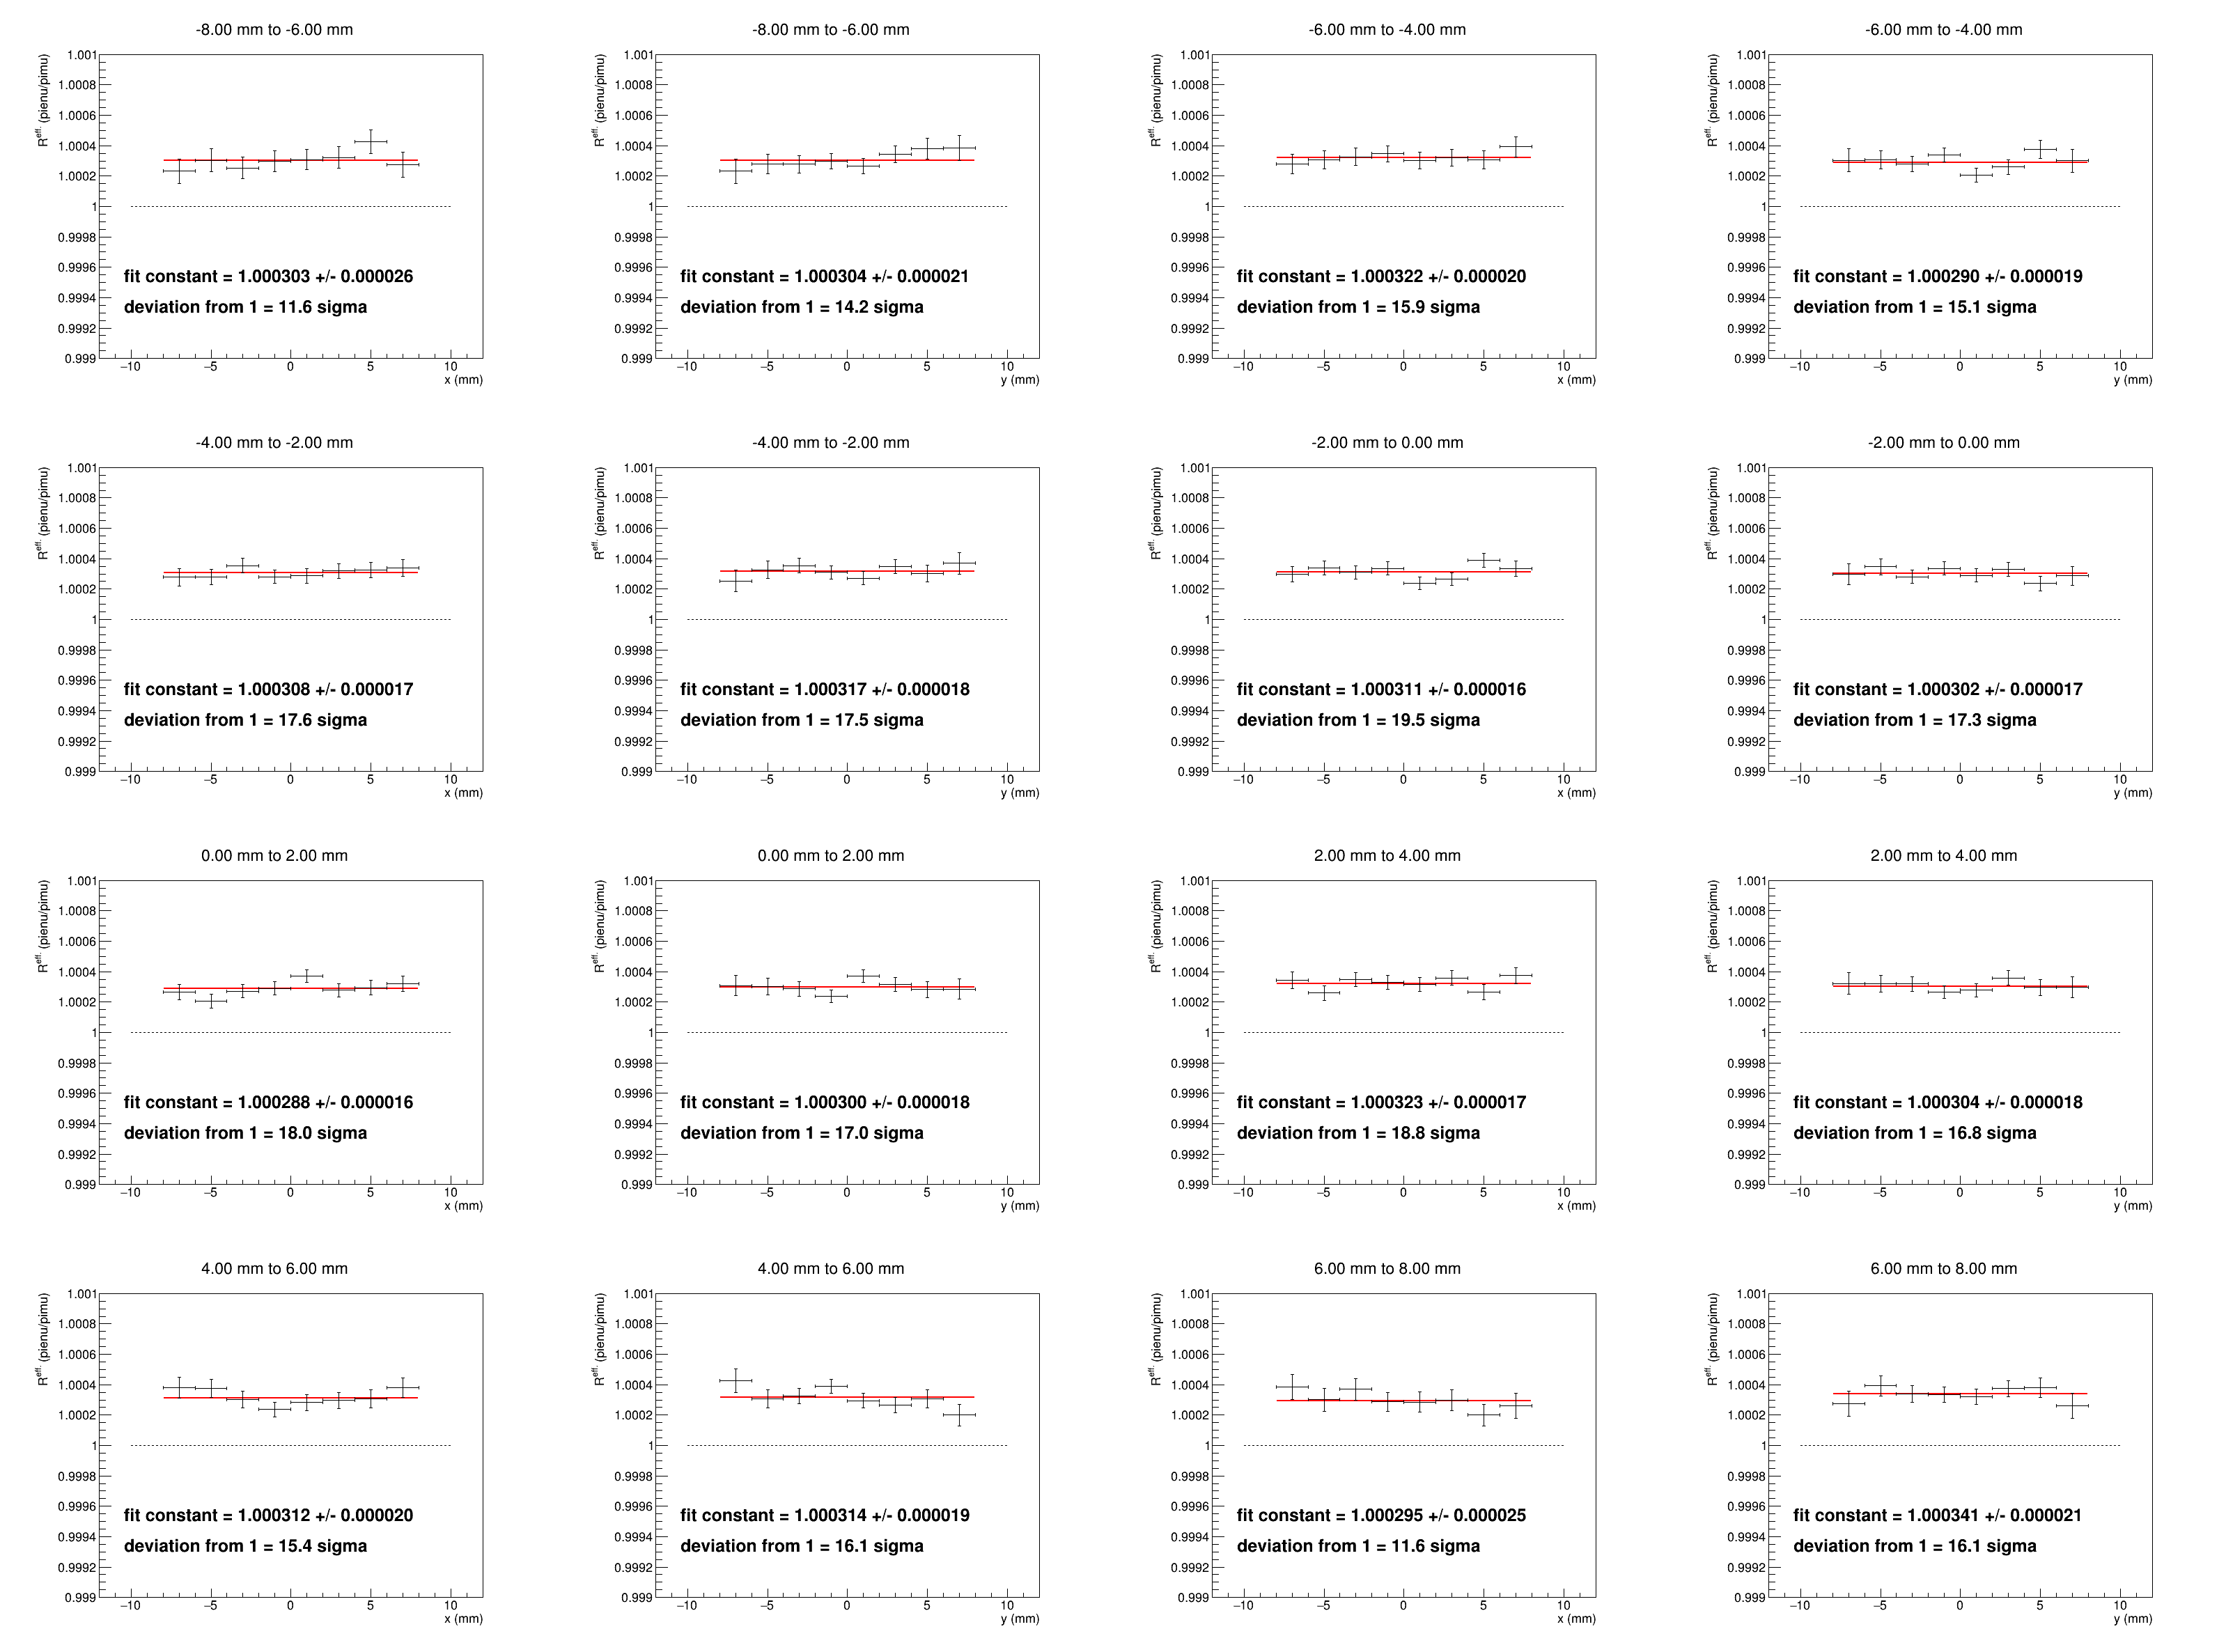

In [62]:
cratio = TCanvas("cratio", "Efficiency", 800*4, 600*4)
cratio.Divide(4, 4)
ratio_pads = []
grs = []
line = ROOT.TLine(-10, 1, 10, 1)
line.SetLineStyle(2)

tex = ROOT.TLatex()

for i in range(8):
    for j in range(2):
        pad = cratio.cd(2*i + j + 1)
        axis = None
        if j == 0:
            axis = 'x'
        if j == 1:
            axis = 'y'
        # gs["pimue"][i][axis].GetY()[0]
        err = {"pienu" : np.zeros(gs["pienu"][i][axis].GetN()),
               "pimue" : np.zeros(gs["pimue"][i][axis].GetN())}
        values = {"pienu" : np.zeros(gs["pienu"][i][axis].GetN()),
               "pimue" : np.zeros(gs["pimue"][i][axis].GetN())}
        centers = {"pienu" : np.zeros(gs["pienu"][i][axis].GetN()),
               "pimue" : np.zeros(gs["pimue"][i][axis].GetN())}
        eh = {"pienu" : np.zeros(gs["pienu"][i][axis].GetN()),
               "pimue" : np.zeros(gs["pimue"][i][axis].GetN())}

        gr = ROOT.TGraphErrors(len(values["pienu"]))

        gr.SetTitle(gs[k][i][axis].GetTitle())
        gr.GetXaxis().SetTitle(gs[k][i][axis].GetXaxis().GetTitle())

        for ip in range(gs["pimue"][i][axis].GetN()):
            for k in ["pienu", "pimue"]:
                err[k][ip] = np.max([gs[k][i][axis].GetEYhigh()[ip], gs[k][i][axis].GetEYlow()[ip]])
                values[k][ip] = gs[k][i][axis].GetY()[ip]
                centers[k][ip] = gs[k][i][axis].GetX()[ip]
                eh[k][ip] = gs[k][i][axis].GetEXlow()[ip]
            x = centers["pienu"][ip]
            ex = eh["pienu"][ip]
            y = values["pienu"][ip] / values["pimue"][ip]
            ey = np.sqrt(err["pienu"][ip]**2 + err["pimue"][ip]**2)
            gr.SetPoint(ip, x, y)
            gr.SetPointError(ip, ex, ey)
        # gs["pimue"][i][axis].Print()
        # gs["pienu"][i][axis].Print()
        pad.SetLeftMargin(0.15)
        gr.GetHistogram().GetYaxis().SetRangeUser(1-1E-3, 1+1E-3)
        gr.GetHistogram().GetYaxis().SetTitle("R^{eff.} (pienu/pimu)")
        f = ROOT.TF1("f", "pol0", -8, 8)
        gr.Fit(f, "RQ", "", -8, 8)


        gr.DrawClone("AP")

        line.DrawClone()
        tex.DrawLatexNDC(0.2, 0.3, "fit constant = {:6f} +/- {:6f}".format(f.GetParameter(0), f.GetParError(0)))
        tex.DrawLatexNDC(0.2, 0.22, "deviation from 1 = {:.1f} sigma".format((f.GetParameter(0)-1)/f.GetParError(0)))

        grs.append(gr)
cratio.Draw()
